In [1]:
from IPython.core.interactiveshell import InteractiveShell
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from scipy.spatial.distance import cdist
from datetime import datetime

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spotipy
import sys
import os
import time
import sklearn

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [4]:
os.chdir(os.path.join(os.path.expanduser("~"),"Desktop"))

In [5]:
import auth

In [6]:
InteractiveShell.ast_node_interactivity = "all"
np.set_printoptions(threshold = sys.maxsize)
pd.set_option("display.max_columns",200)
pd.set_option("display.max_rows",200)

In [10]:
sp = spotipy.Spotify(client_credentials_manager = SpotifyClientCredentials(client_id = os.environ["client_id"], client_secret = os.environ["client_secret"]),
auth_manager = SpotifyOAuth(client_id = os.environ["client_id"], client_secret = os.environ["client_secret"],redirect_uri = os.environ["redirect_uri"]))

In [11]:
#This is the notebook for analyzing the recently playlists from my spotify premium account. The recently playlists returns the recent 50 tracks played by a user(duplicated songs could be found). The track that is currently playing will not be visible until it has completed and a track must be played for 30 seconds to be included in the recently played lists. 

In [12]:
#Read the recently playlist
recent = sp.current_user_recently_played(limit =50)
print(len(recent["items"])) #50 items --> There is no way to get the more than 50 items only if we set the exatly time for the parameter "before"

50


In [17]:
#TBD(Need to check the functions)
def get_recent_playlist(sp_object,limit):
    items = []
    dates_min = datetime.now().timestamp()*1000
    if limit >= 50:
        limit_count = limit
        while limit_count >= 50:
            recent0 = sp_object.current_user_recently_played(limit = 50,before = int(dates_min))
            items.extend(recent0["items"])
            limit_count = limit_count - 50
            for i in range(len(recent0["items"])):
                try:
                    played_at = datetime.strptime(recent0["items"][i]["played_at"],"%Y-%m-%dT%H:%M:%S.%fZ").timestamp()*1000
                except:
                    try:
                        played_at = datetime.strptime(recent0["items"][i]["played_at"],"%Y-%m-%dT%H:%M:%fZ").timestamp()*1000
                    except:
                        try:
                            played_at = datetime.strptime(recent0["items"][i]["played_at"],"%Y-%m-%dT%H:%fZ").timestamp()*1000
                        except:
                            played_at = datetime.strptime(recent0["items"][i]["played_at"],"%Y-%m-%dT%fZ").timestamp()*1000
                if played_at <= dates_min:
                    dates_min = played_at
        if limit_count != 0:
            recent_final = sp_object.current_user_recently_played(limit = limit_count,before = int(dates_min))
            items.extend(recent_final["items"])
    else:
        recent_final = sp_object.current_user_recently_played(limit = limit)
        items.extend(recent_final["items"])
    return items

In [37]:
test = get_recent_playlist(sp,limit = 20000)
print(len(test))

449


In [34]:
#Extract the recently played track lists
#lib = {}
#lib["artist_name"],lib["artist_uri"] = [],[]
#lib["album_name"],lib["album_uri"] = [],[]
#lib["album_market"],lib["album_type"] = [],[]
#lib["album_genres"],lib["album_total_tracks"] = [], []
#lib["album_pop"],lib["album_release_date"] = [],[]
#lib["track_name"],lib["track_uri"] = [],[]
#lib["track_duration"],lib["track_pop"] = [],[]
#lib["track_market"],lib["danceability"] = [],[]
#lib["track_number"] = []
#lib["energy"],lib["key"] = [],[]
#lib["loudness"],lib["mode"] = [],[]
#lib["speechiness"],lib["acousticness"] = [],[]
#lib["instrumentalness"],lib["liveness"]= [],[]
#lib["valence"],lib["tempo"] = [],[]
#lib["time_signature"] = []
#for i in range(len(test)):
   # lib["artist_name"].append(test[i]["track"]["artists"][0]["name"])
   # lib["artist_uri"].append(test[i]["track"]["artists"][0]["uri"])
   # lib["album_name"].append(test[i]["track"]["album"]["name"])
   # lib["album_uri"].append(test[i]["track"]["album"]["uri"])
   # lib["album_market"].append(",".join(test[i]["track"]["album"]["available_markets"]))
   # lib["album_type"].append(test[i]["track"]["album"]["album_type"])
   # album0 = sp.album(test[i]["track"]["album"]["uri"])
   # lib["album_genres"].append(",".join(album0["genres"]))
   # lib["album_total_tracks"].append(album0["total_tracks"])
   # lib["album_pop"].append(album0["popularity"])
   # lib["album_release_date"].append(album0["release_date"])
   # lib["track_name"].append(test[i]["track"]["name"])
   # lib["track_uri"].append(test[i]["track"]["uri"])
   # lib["track_number"].append(test[i]["track"]["track_number"])
   # lib["track_duration"].append(test[i]["track"]["duration_ms"])
   # lib["track_pop"].append(test[i]["track"]["popularity"])
   # lib["track_market"].append(",".join(test[i]["track"]["available_markets"]))
   # audio0 = sp.audio_features(test[i]["track"]["uri"])[0]
   # lib["danceability"].append(audio0["danceability"])
   # lib["energy"].append(audio0["energy"])
   # lib["key"].append(audio0["key"])
   # lib["loudness"].append(audio0["loudness"])
   # lib["mode"].append(audio0["mode"])
   # lib["speechiness"].append(audio0["speechiness"])
   # lib["acousticness"].append(audio0["acousticness"])
   # lib["instrumentalness"].append(audio0["instrumentalness"])
   # lib["liveness"].append(audio0["liveness"])
   # lib["valence"].append(audio0["valence"])
   # lib["tempo"].append(audio0["tempo"])
   # lib["time_signature"].append(audio0["time_signature"])
   # if i%5 == 0:
      #  time.sleep(np.random.uniform(2,5))

In [39]:
#test_lib = pd.DataFrame.from_dict(lib)
#test_lib.shape
#test_lib.drop_duplicates(["track_name"]).shape --> there are multiple songs repeatly played. 

(449, 28)

(34, 28)

In [17]:
my_color = {"light_blue":"#7FB3D5"}

In [213]:
#Designed format: artist_name --> artist_uri --> track --> track_uri --> track_number --> track_duration --> album_name --> album_uri --> album_available_market --> album_type --> album_genres --> album_release_date -->  total_tracks  --> album_popularity --> track_popularity --> audio_features

In [214]:
#Extract the recently played track lists
lib = {}
lib["artist_name"],lib["artist_uri"] = [],[]
lib["album_name"],lib["album_uri"] = [],[]
lib["album_market"],lib["album_type"] = [],[]
lib["album_genres"],lib["album_total_tracks"] = [], []
lib["album_pop"],lib["album_release_date"] = [],[]
lib["track_name"],lib["track_uri"] = [],[]
lib["track_duration"],lib["track_pop"] = [],[]
lib["track_market"],lib["danceability"] = [],[]
lib["track_number"] = []
lib["energy"],lib["key"] = [],[]
lib["loudness"],lib["mode"] = [],[]
lib["speechiness"],lib["acousticness"] = [],[]
lib["instrumentalness"],lib["liveness"]= [],[]
lib["valence"],lib["tempo"] = [],[]
lib["time_signature"] = []
for i in range(len(recent["items"])):
    lib["artist_name"].append(recent["items"][i]["track"]["artists"][0]["name"])
    lib["artist_uri"].append(recent["items"][i]["track"]["artists"][0]["uri"])
    lib["album_name"].append(recent["items"][i]["track"]["album"]["name"])
    lib["album_uri"].append(recent["items"][i]["track"]["album"]["uri"])
    lib["album_market"].append(",".join(recent["items"][i]["track"]["album"]["available_markets"]))
    lib["album_type"].append(recent["items"][i]["track"]["album"]["album_type"])
    album0 = sp.album(recent["items"][i]["track"]["album"]["uri"])
    lib["album_genres"].append(",".join(album0["genres"]))
    lib["album_total_tracks"].append(album0["total_tracks"])
    lib["album_pop"].append(album0["popularity"])
    lib["album_release_date"].append(album0["release_date"])
    lib["track_name"].append(recent["items"][i]["track"]["name"])
    lib["track_uri"].append(recent["items"][i]["track"]["uri"])
    lib["track_number"].append(recent["items"][i]["track"]["track_number"])
    lib["track_duration"].append(recent["items"][i]["track"]["duration_ms"])
    lib["track_pop"].append(recent["items"][i]["track"]["popularity"])
    lib["track_market"].append(",".join(recent["items"][i]["track"]["available_markets"]))
    audio0 = sp.audio_features(recent["items"][i]["track"]["uri"])[0]
    lib["danceability"].append(audio0["danceability"])
    lib["energy"].append(audio0["energy"])
    lib["key"].append(audio0["key"])
    lib["loudness"].append(audio0["loudness"])
    lib["mode"].append(audio0["mode"])
    lib["speechiness"].append(audio0["speechiness"])
    lib["acousticness"].append(audio0["acousticness"])
    lib["instrumentalness"].append(audio0["instrumentalness"])
    lib["liveness"].append(audio0["liveness"])
    lib["valence"].append(audio0["valence"])
    lib["tempo"].append(audio0["tempo"])
    lib["time_signature"].append(audio0["time_signature"])
    if i%5 == 0:
        time.sleep(np.random.uniform(2,5))


In [215]:
lib_df = pd.DataFrame.from_dict(lib)

In [216]:
lib_df_non = lib_df.drop_duplicates()

In [217]:
columns = ["track_duration_minute","track_pop","danceability","track_number","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","time_signature","year","month","day"]

In [219]:
lib_df["album_release_date"].head(4)

0    2007-07-13
1    2012-06-01
2    2018-01-10
3    2012-06-01
Name: album_release_date, dtype: object

In [220]:
#Convert the track_duration from milliseconds to minutes
lib_df["track_duration_minute"] = lib_df["track_duration"]/(1000*60)
#Convert the date object to date format
lib_df["album_release_date"] = pd.to_datetime(lib_df["album_release_date"],format = "%Y-%m-%d")
#Get the year, month and day from the date
lib_df["year"] = lib_df.album_release_date.dt.year
lib_df["month"] = lib_df.album_release_date.dt.month
lib_df["day"] = lib_df.album_release_date.dt.day

(array([ 1.,  0.,  6.,  2.,  3., 16.,  9.,  5.,  2.,  6.]),
 array([2.1       , 2.41932833, 2.73865667, 3.057985  , 3.37731333,
        3.69664167, 4.01597   , 4.33529833, 4.65462667, 4.973955  ,
        5.29328333]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'track_duration_minute')

(array([ 1.,  2.,  3.,  8., 11.,  8.,  6.,  5.,  5.,  1.]),
 array([ 1. ,  8.1, 15.2, 22.3, 29.4, 36.5, 43.6, 50.7, 57.8, 64.9, 72. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'track_pop')

(array([ 2.,  2.,  6.,  6., 11.,  8.,  4.,  7.,  3.,  1.]),
 array([0.291 , 0.3434, 0.3958, 0.4482, 0.5006, 0.553 , 0.6054, 0.6578,
        0.7102, 0.7626, 0.815 ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'danceability')

(array([22.,  4.,  7., 10.,  1.,  1.,  2.,  0.,  1.,  2.]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'track_number')

(array([ 1.,  2., 10.,  7.,  6.,  7.,  6.,  6.,  3.,  2.]),
 array([0.23  , 0.3001, 0.3702, 0.4403, 0.5104, 0.5805, 0.6506, 0.7207,
        0.7908, 0.8609, 0.931 ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'energy')

(array([13.,  2.,  3.,  5.,  2.,  5.,  4.,  3.,  4.,  9.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'key')

(array([ 1.,  3.,  3.,  9.,  3.,  4., 15.,  4.,  5.,  3.]),
 array([-11.958 , -11.1013, -10.2446,  -9.3879,  -8.5312,  -7.6745,
         -6.8178,  -5.9611,  -5.1044,  -4.2477,  -3.391 ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'loudness')

(array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 39.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'mode')

(array([37.,  8.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0.0251 , 0.05009, 0.07508, 0.10007, 0.12506, 0.15005, 0.17504,
        0.20003, 0.22502, 0.25001, 0.275  ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'speechiness')

(array([4., 4., 7., 6., 6., 3., 6., 8., 3., 3.]),
 array([0.00571 , 0.100539, 0.195368, 0.290197, 0.385026, 0.479855,
        0.574684, 0.669513, 0.764342, 0.859171, 0.954   ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'acousticness')

(array([48.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.     , 0.00459, 0.00918, 0.01377, 0.01836, 0.02295, 0.02754,
        0.03213, 0.03672, 0.04131, 0.0459 ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'instrumentalness')

(array([20.,  9.,  6.,  4.,  7.,  0.,  0.,  0.,  0.,  4.]),
 array([0.07  , 0.1043, 0.1386, 0.1729, 0.2072, 0.2415, 0.2758, 0.3101,
        0.3444, 0.3787, 0.413 ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'liveness')

(array([ 3., 12.,  3.,  7.,  9.,  5.,  2.,  4.,  3.,  2.]),
 array([0.117 , 0.1809, 0.2448, 0.3087, 0.3726, 0.4365, 0.5004, 0.5643,
        0.6282, 0.6921, 0.756 ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'valence')

(array([ 3.,  7.,  9.,  5., 11.,  5.,  4.,  1.,  1.,  4.]),
 array([ 76.503 ,  87.4557,  98.4084, 109.3611, 120.3138, 131.2665,
        142.2192, 153.1719, 164.1246, 175.0773, 186.03  ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'tempo')

(array([ 2.,  0.,  0.,  0.,  0., 43.,  0.,  0.,  0.,  5.]),
 array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'time_signature')

(array([ 3.,  2.,  4.,  2.,  0.,  4.,  7.,  4., 11., 13.]),
 array([2002. , 2003.8, 2005.6, 2007.4, 2009.2, 2011. , 2012.8, 2014.6,
        2016.4, 2018.2, 2020. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'year')

(array([ 5.,  0.,  4.,  2.,  4.,  3., 11.,  8.,  2., 11.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'month')

(array([15.,  4.,  8.,  4.,  4.,  7.,  6.,  0.,  0.,  2.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'day')

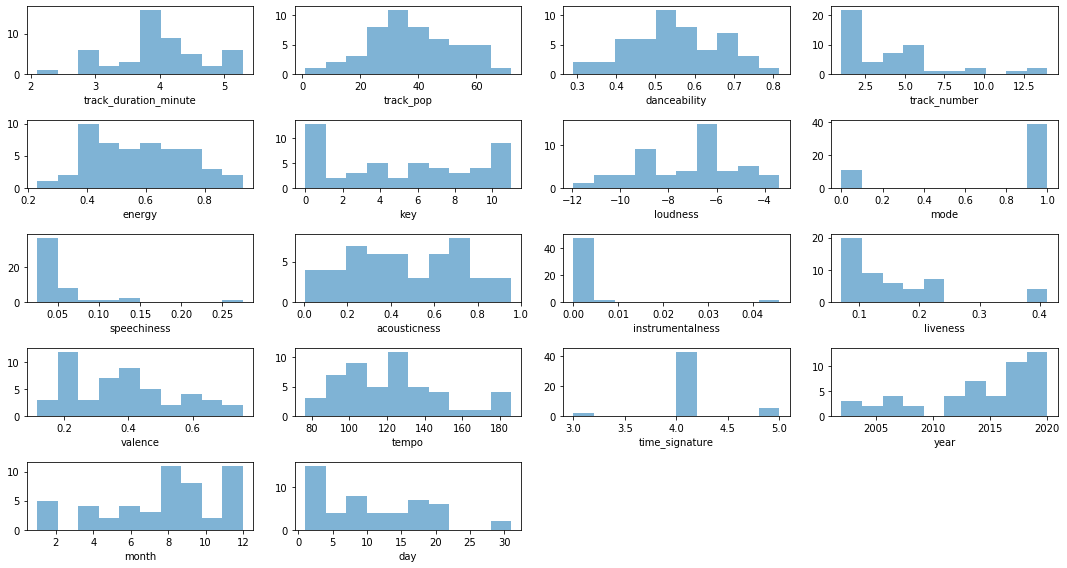

In [221]:
#Here, I didn't drop the duplicately listened songs,since I want to know the distribution of the features from all the songs that I recently listened to. 
fig,axes = plt.subplots(nrows = 5,ncols = 4,figsize = (15,8))
for i in range(5):
    for j in range(4):
        if (4*i+j)<18:
            axes[i,j].hist(lib_df[columns[(j+i*4)]],color = my_color["light_blue"])
            axes[i,j].set_xlabel(str(columns[j+i*4]))
        #axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(),rotation = 45,horizontalalignment='right')
fig.tight_layout()
fig.delaxes(ax = axes[4,2])
fig.delaxes(ax = axes[4,3])

In [222]:
#Most of the songs that I listened is energetic,loud but not instrumental, acoustic or live, which means I uaually like to listen high tempo songs. Also, most of the songs that I listened are released between 2010 and 2020 and less than 4.5 minutes. However, it seems I have a slight preference on the depressed songs. :(

In [223]:
#Let's do a quick clustering analysis to see if the recently played songs can be divided into seveal categories or not.abs using the existing features(This can be extended to other songs as well (like the songs from the saved albums/tracks/current_playlist,etc.)

In [224]:
lib_df.drop_duplicates().shape #39 songs
lib_df_dropped = lib_df.drop_duplicates().drop(columns = ["artist_uri","album_uri","track_uri","album_release_date"])

(39, 32)

In [225]:
cate_cols = ["artist_name","album_name","album_market","album_type","album_genres","track_name","track_market","year","month","day"]
cate_df = pd.DataFrame.to_numpy(lib_df_dropped[cate_cols])
lib_df_dropped = lib_df_dropped.drop(columns = cate_cols).reset_index(drop = True)

In [226]:
enc = OneHotEncoder(handle_unknown = "ignore")
array_df = pd.DataFrame(enc.fit_transform(cate_df).toarray())

In [227]:
df_com = lib_df_dropped.join(array_df)

In [228]:
#K-means-clustering
#(1) Standardize the scaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_com)

In [229]:
#Choose the best K for k-means-clustering with elbow method
ks = range(2,6)

In [230]:
distortions,inertias = {},{}
distortions2,inertias2 = {},{}
for k in ks:
    k_model = KMeans(n_clusters = k,max_iter = 1000).fit(scaled_features) #scaled_features,
    #scaled_features["clusters"] = k_model.labels_
    dist0 = sum(np.min(cdist(scaled_features,k_model.cluster_centers_,"euclidean"),axis = 1))/scaled_features.shape[0] #distortions  MSE
    dist1 = sum(np.min(cdist(scaled_features,k_model.cluster_centers_,"euclidean"),axis = 1)) #inertias SSE 
    distortions[k],inertias[k] = dist0, dist1

    distortions2[k],inertias2[k] = k_model.inertia_/scaled_features.shape[0], k_model.inertia_ #SSE. 


Text(0.5, 0, 'Value of k')

Text(0, 0.5, 'distortion')

Text(0.5, 0, 'value of k')

Text(0, 0.5, 'distortion')

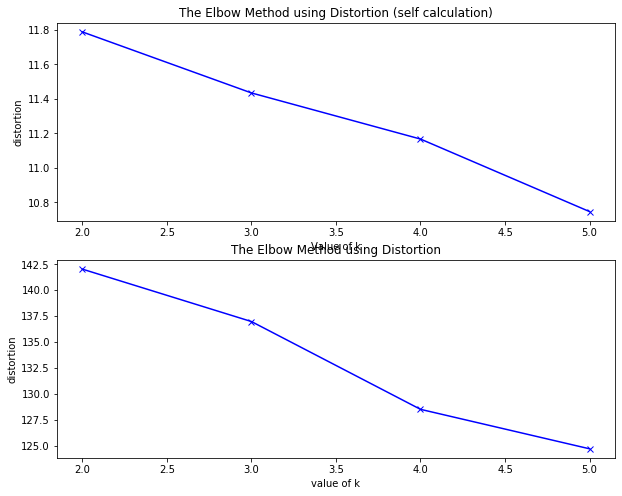

In [231]:
#Visualize the result (distortion)
fig, axes = plt.subplots(2,figsize = (10,8))
axes[0].plot(ks,list(distortions.values()),"bx-")
axes[0].set_xlabel("Value of k")
axes[0].set_ylabel("distortion")
axes[0].title.set_text("The Elbow Method using Distortion (self calculation)")
axes[1].plot(ks,list(distortions2.values()),"bx-")
axes[1].set_xlabel("value of k")
axes[1].set_ylabel("distortion")
axes[1].title.set_text("The Elbow Method using Distortion")
plt.show()

Text(0.5, 0, 'Value of k')

Text(0, 0.5, 'distortion')

Text(0.5, 0, 'value of k')

Text(0, 0.5, 'distortion')

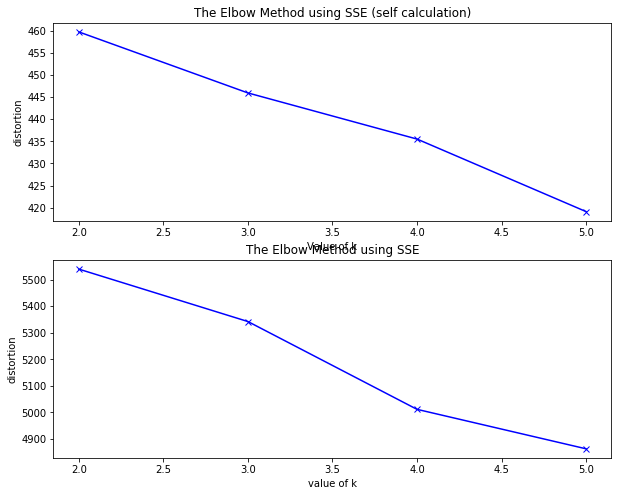

In [232]:
#Visualize the result (SSE)
fig, axes = plt.subplots(2,figsize = (10,8))
axes[0].plot(ks,list(inertias.values()),"bx-")
axes[0].set_xlabel("Value of k")
axes[0].set_ylabel("distortion")
axes[0].title.set_text("The Elbow Method using SSE (self calculation)")
axes[1].plot(ks,list(inertias2.values()),"bx-")
axes[1].set_xlabel("value of k")
axes[1].set_ylabel("distortion")
axes[1].title.set_text("The Elbow Method using SSE")
plt.show()

In [193]:
#looks like there is no optimal parameter k for K-means-clustering, the SSE keeps decreasing. Since we only got 39 different songs for the analysis, We'll have to see if there will be clear division(clusters) when we got more data.